In [77]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
ds_version = "V9"
root_data_path = os.path.join("..", "data", "training", ds_version)
data_path = os.path.join(root_data_path, "metadata")

In [79]:
# without cropping
file_names = ["asphalt_prediction-V6_annotated_asphalt-20240214_151246.csv",
               "concrete_prediction-V6_annotated_concrete-20240214_151256.csv",
               "paving_stones_prediction-V6_annotated_paving_stones-20240214_151307.csv",
               "sett_prediction-V6_annotated_sett-20240214_151316.csv",
               "unpaved_prediction-V6_annotated_unpaved-20240214_151329.csv"]

In [80]:
# with cropping
file_names = ["asphalt_prediction-V9_annotated_asphalt-20240315_120212.csv",
            "concrete_prediction-V9_annotated_concrete-20240315_120226.csv",
            "paving_stones_prediction-V9_annotated_paving_stones-20240315_120246.csv",
            "sett_prediction-V9_annotated_sett-20240315_120307.csv",
            "unpaved_prediction-V9_annotated_unpaved-20240315_120321.csv"
            ]

In [81]:
pred = pd.DataFrame()
for file_name in file_names:
    surface = file_name.split("_")[0]
    print(f"reading {file_name}")
    df = pd.read_csv(os.path.join(data_path, "model_predictions", file_name))
    df["surface_pred"] = surface
    pred = pd.concat([pred, df])

pred.rename(columns={"Image": "image_id", "Prediction": "quality_float_pred", "Level_0": "quality_label_pred"}, inplace=True)

reading asphalt_prediction-V9_annotated_asphalt-20240315_120212.csv
reading concrete_prediction-V9_annotated_concrete-20240315_120226.csv
reading paving_stones_prediction-V9_annotated_paving_stones-20240315_120246.csv
reading sett_prediction-V9_annotated_sett-20240315_120307.csv
reading unpaved_prediction-V9_annotated_unpaved-20240315_120321.csv


In [82]:
annot = pd.read_csv(os.path.join(data_path, "annotations_combined.csv"))
annot.rename(columns={"surface": "surface_true", "smoothness": "quality_label_true"}, inplace=True)
annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [83]:
df = pred.set_index("image_id").join(annot[["image_id", "surface_true", "quality_label_true", "quality_float_true"]].set_index("image_id"), how="left")

In [84]:
df.groupby(["surface_true", "quality_label_true"]).size()

surface_true   quality_label_true
asphalt        bad                    113
               excellent              716
               good                  1251
               intermediate           598
concrete       bad                     53
               excellent              189
               good                   330
               intermediate           242
paving_stones  bad                     23
               excellent              326
               good                   668
               intermediate           191
sett           bad                    508
               good                    91
               intermediate           650
unpaved        bad                    332
               intermediate           293
               very_bad               155
dtype: int64

In [85]:
df_valid = df[df.is_in_validation == 1]
df_train = df[df.is_in_validation == 0]

In [86]:
df.groupby(["is_in_validation", "surface_true", "quality_label_true"]).size().to_csv("test.csv")

## Global measures

In [87]:
def compute_measures(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

In [88]:
# all
gm = compute_measures(df.quality_float_true, df.quality_float_pred)
gm_valid = compute_measures(df_valid.quality_float_true, df_valid.quality_float_pred)
gm_train = compute_measures(df_train.quality_float_true, df_train.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(2)

,all,validation,train
accuracy,0.84,0.60,0.90
correlation,0.94,0.84,0.97
r_square,0.86,0.67,0.91
mse,0.15,0.34,0.10
rmse,0.38,0.59,0.31


## Measures by surface class

In [89]:
# all
gm_surface = pd.DataFrame()
for surface in df.surface_true.unique():
    df_ = df[df.surface_true == surface]
    gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.87,0.85,0.81,0.90,0.67
correlation,0.92,0.93,0.88,0.89,0.83
r_square,0.81,0.81,0.68,0.72,0.51
mse,0.13,0.14,0.16,0.10,0.26
rmse,0.36,0.38,0.40,0.32,0.51


In [90]:
# all
gm_surface = pd.DataFrame()
for surface in df.surface_true.unique():
    df_ = df[df.surface_true == surface]
    gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.87,0.85,0.81,0.90,0.67
correlation,0.92,0.93,0.88,0.89,0.83
r_square,0.81,0.81,0.68,0.72,0.51
mse,0.13,0.14,0.16,0.10,0.26
rmse,0.36,0.38,0.40,0.32,0.51


In [91]:
# only validation
gm_surface = pd.DataFrame()
for surface in df_valid.surface_true.unique():
    df_ = df_valid[df_valid.surface_true == surface]
    gm = compute_measures(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.60,0.58,0.60,0.70,0.47
correlation,0.72,0.76,0.63,0.65,0.63
r_square,0.47,0.53,0.30,0.33,0.17
mse,0.35,0.36,0.35,0.25,0.45
rmse,0.59,0.60,0.59,0.50,0.67


## compare float values

In [92]:
df = df_valid
# df = df_train

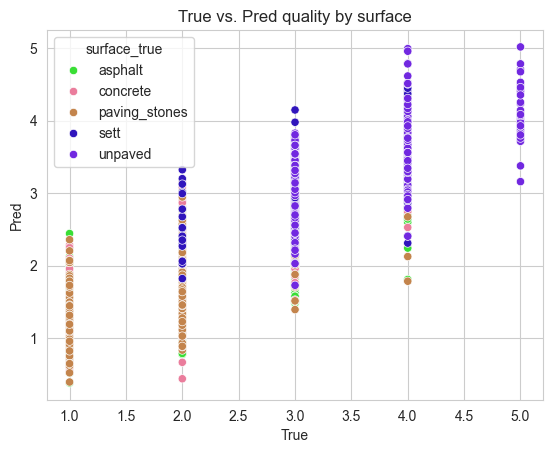

In [93]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df.surface_true.unique()}

sns.scatterplot(data=df, x="quality_float_true", y="quality_float_pred", hue="surface_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


In [94]:
df_train[(df_train.quality_label_true != df_train.quality_label_pred)&(df_train.quality_label_pred!= "outside")]


,quality_float_pred,quality_label_pred,is_in_validation,surface_pred,surface_true,quality_label_true,quality_float_true
image_id,,,,,,,
204913651447887,1.502196,good,0.0,asphalt,asphalt,excellent,1.0
1213730279140607,1.476659,excellent,0.0,asphalt,asphalt,good,2.0
1237374763403565,1.464303,excellent,0.0,asphalt,asphalt,good,2.0
126341579452762,1.491067,excellent,0.0,asphalt,asphalt,good,2.0
1326662941060757,1.409393,excellent,0.0,asphalt,asphalt,good,2.0
...,...,...,...,...,...,...,...
550542793891988,4.324500,bad,0.0,unpaved,unpaved,very_bad,5.0
675156250450656,4.216507,bad,0.0,unpaved,unpaved,very_bad,5.0
817911575510311,3.942611,bad,0.0,unpaved,unpaved,very_bad,5.0


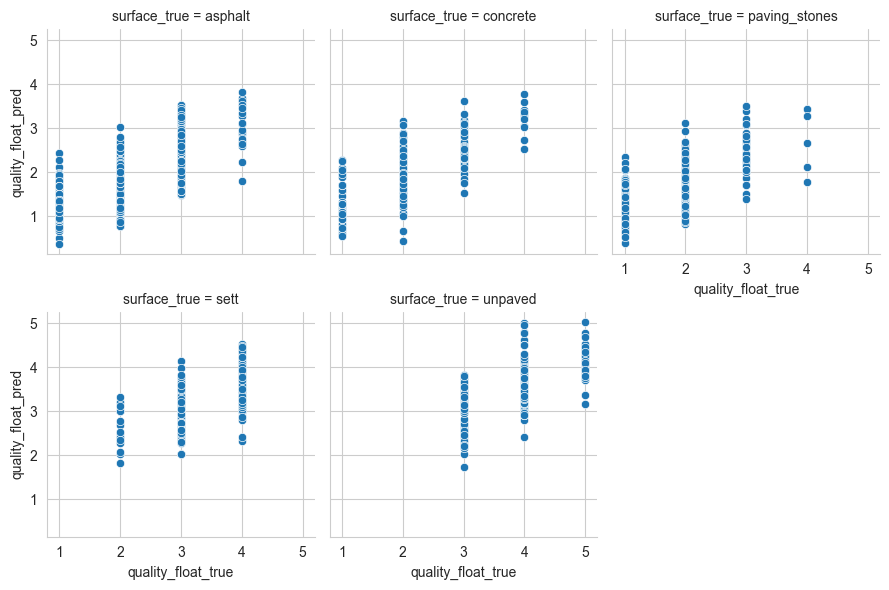

In [95]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [96]:
df["deviation"] = df.quality_float_true - df.quality_float_pred

**Overall**

<Axes: >

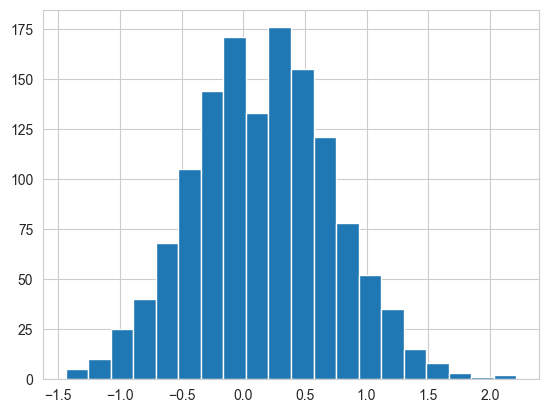

In [97]:
df.deviation.hist(bins=20)

**by surface**

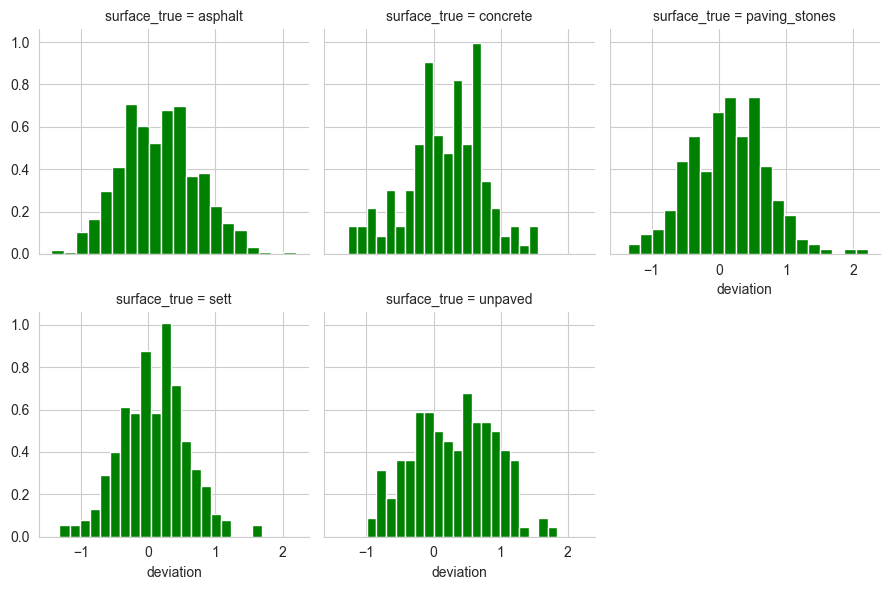

In [98]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df, col="surface_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

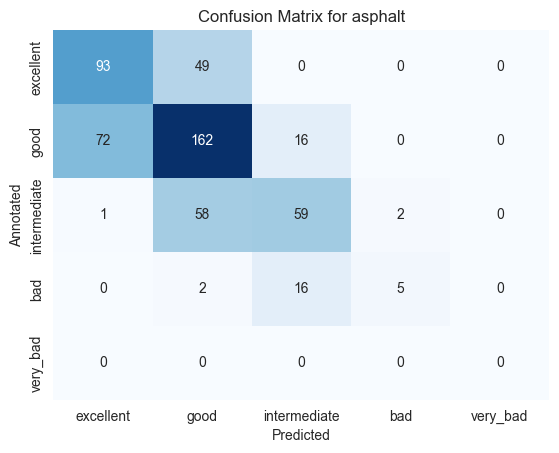

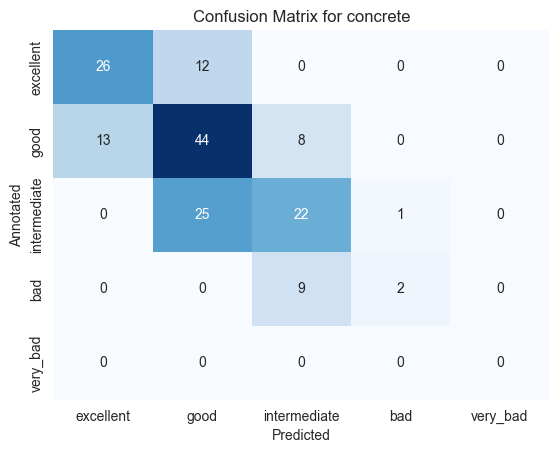

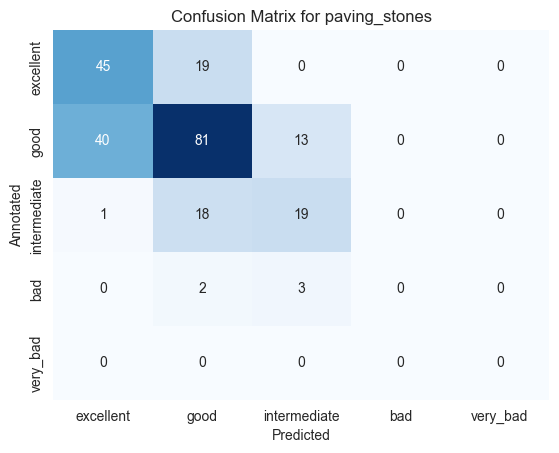

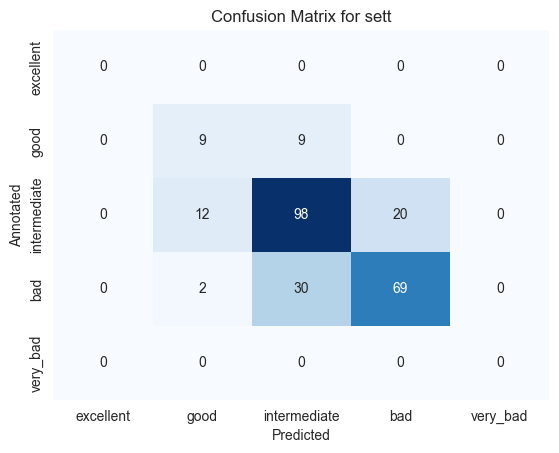

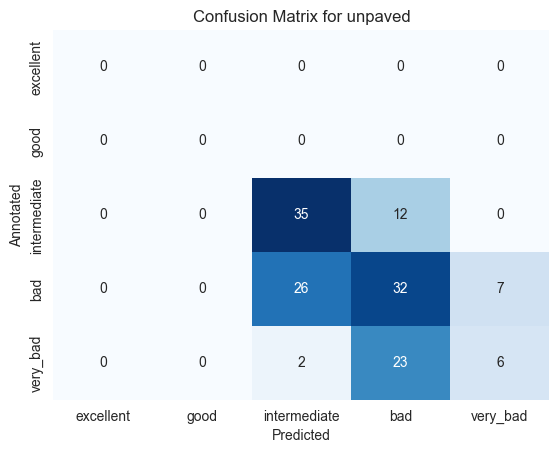

In [99]:
# Plotting the confusion matrix using seaborn heatmap
for surface in df.surface_true.unique():
    _df = df[df.surface_true == surface]
    cm = confusion_matrix(_df.quality_label_true, _df.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()

In [100]:
# Extract predicted and ground truth values
for class_name in df['surface_true'].unique():
    _df = df[df['surface_true'] == class_name]
    class_precision = precision_score(_df.quality_label_true, _df.quality_label_pred, average='weighted')
    class_recall = recall_score(_df.quality_label_true, _df.quality_label_pred, average='weighted')

    print(f"Class: {class_name}")
    print(f"Count: {len(_df)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")


Class: asphalt
Count: 536
Precision: 0.6
Recall: 0.6
------------------------
Class: concrete
Count: 163
Precision: 0.59
Recall: 0.58
------------------------
Class: paving_stones
Count: 242
Precision: 0.6
Recall: 0.6
------------------------
Class: sett
Count: 250
Precision: 0.72
Recall: 0.7
------------------------
Class: unpaved
Count: 156
Precision: 0.5
Recall: 0.47
------------------------


/Users/edith/git/SurfaceAI/classification_models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edith/git/SurfaceAI/classification_models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edith/git/SurfaceAI/classification_models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

In [101]:
# all images that were incorrectly classified
df["deviation_abs"] = abs(df.deviation)    
# misclassification = df[(df.deviation_abs > 1) & (df.is_in_validation == 1)]
misclassification = df[(df.quality_label_pred != df.quality_label_true) & (df.is_in_validation == 1)]

In [102]:
misclassification = misclassification.sort_values("image_id")
misclassification.reset_index( inplace=True)
misclassification[["image_id", "is_in_validation", 
                   "surface_true", "surface_pred", "quality_float_pred", "quality_float_true", 
                   "quality_label_pred", "quality_label_true", "deviation"]
                   ].to_csv(os.path.join(data_path, "model_predictions", "misclassification.csv"), index=False)

In [103]:
misclassification
df

,quality_float_pred,quality_label_pred,is_in_validation,surface_pred,surface_true,quality_label_true,quality_float_true,deviation,deviation_abs
image_id,,,,,,,,,
1178313585927604,2.641968,intermediate,1.0,asphalt,asphalt,bad,4.0,1.358032,1.358032
1341835419633858,3.638382,bad,1.0,asphalt,asphalt,bad,4.0,0.361618,0.361618
1349900185630750,3.696705,bad,1.0,asphalt,asphalt,bad,4.0,0.303295,0.303295
1382963682081381,2.666483,intermediate,1.0,asphalt,asphalt,bad,4.0,1.333517,1.333517
1391166841241877,1.807984,good,1.0,asphalt,asphalt,bad,4.0,2.192016,2.192016
...,...,...,...,...,...,...,...,...,...
833267997315412,4.672671,very_bad,1.0,unpaved,unpaved,very_bad,5.0,0.327329,0.327329
875824797090756,4.455175,bad,1.0,unpaved,unpaved,very_bad,5.0,0.544825,0.544825
882954962284466,3.927220,bad,1.0,unpaved,unpaved,very_bad,5.0,1.072780,1.072780


In [104]:
# store missclassified images in folder
import shutil

path = os.path.join(data_path, "model_predictions", "misclassified_images")
os.makedirs(path, exist_ok=True)
for i in range(len(misclassification)):  # len(misclassification)
    img = misclassification.loc[i]
    img_path = os.path.join(root_data_path, "annotated")
    destination_folder_path = os.path.join(path, img.surface_true, img.quality_label_true, img.quality_label_pred)
    os.makedirs(destination_folder_path, exist_ok=True)
    destination_path = os.path.join(destination_folder_path, f"{img.image_id}.jpg")
    image_filename = os.path.join(img_path, img.surface_true, img.quality_label_true, f"{img.image_id}.jpg")
    shutil.copy(image_filename, destination_path)

In [105]:
# store missclassified images in folder
# path = "/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/metadata/model_predictions/VGG16_V4_not_annotated/missclassified_wo_nostreet"
# os.makedirs(path, exist_ok=True)
# for image_id in misclassification_wo_nostreet.index:
#     destination_path = os.path.join(path, f"{image_id}.jpg")
#     image_filename = os.path.join("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/unsorted_images", f"{image_id}.jpg")
#     shutil.copy(image_filename, destination_path)